Mostly based on this notebook: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_3_text_generation.ipynb

# Import libraries

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
import numpy as np
import random
import sys
import io
import re

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import LambdaCallback

# List of devices
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Open quotes text file

In [4]:
f = open(f'{drive_path}/quotes.txt', 'r', encoding = 'utf-8')
lines = f.readlines()
lines_count = len(lines)
f.close()
new_lines_count = lines_count // 6

print(f'Lines count in the quotes file: {lines_count}')
print(f'Lines count in the shorter version of file: {new_lines_count}')

f = open(f'{drive_path}/quotes.txt', 'r', encoding = 'utf-8')
g = open(f'{drive_path}/quotes_one_sixth_version.txt', 'w', encoding = 'utf-8')
for i in range(0, new_lines_count):
    line = f.readline()
    g.write(line)
f.close()
g.close()

Lines count in the quotes file: 67086
Lines count in the shorter version of file: 11181


In [5]:
# file_path = f'{drive_path}/quotes.txt'
file_path = f'{drive_path}/quotes_one_sixth_version.txt'
f = open(file_path, 'r', encoding = 'utf-8')
quotes = f.readlines()
f.close()

print(f'Quotes count: {len(quotes)}')

Quotes count: 11181


In [6]:
raw_text = ''.join(quotes)

print(f'Raw text length: {len(raw_text)}')

Raw text length: 1671104


# Text preprocessing

In [8]:
raw_text[:1000]

'— Достаточно, — резко оборвала его Рейна. — Аннабет говорит правду. Она пришла с миром. Кроме того...— Рейна посмотрела на Аннабет с невольным уважением. — Перси высоко о тебе отзывался. Подтекст в голосе Рейны занял у Аннабет мгновение, чтобы понять его. Взгляд Перси был устремлен вниз, внезапно заинтересовавшись лежащим на тарелке чизбургером. Лицо Аннабет запылало. О, Боги... Рейна пыталась сблизиться с Перси. Это объясняло оттенок горечи, возможно даже зависти в её словах. Перси предпочел ей Аннабет. В тот момент, Аннабет простила своему нелепому парню все, что он когда-либо делал неправильно. Она хотела обнять его, но приказала себе оставаться спокойной.\nРоссия стоит между Азией и Европой. Мы вам сделали теплицу. Вы в теплице. Согреваетесь под теплым солнышком, потому что на ваши головы не падают бомбы. Потому что на Востоке стоит русская армия!\nМы убьем его добротой, но только вместо доброты используем оружие.\nДамы, не худейте. Оно вам надо? Уж лучше к старости бы

In [9]:
processed_text = raw_text.lower()
# processed_text = re.sub(r'[^\x00-\x7f]', r'', processed_text)
chars = sorted(list(set(processed_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'Corpus length: {len(processed_text)}')
print(f'Total chars: {len(chars)}')

Corpus length: 1671104
Total chars: 135


# Build the sentence sequences

In [10]:
maxlen = 50
step = 10
sentences = []
next_chars = []
for i in range(0, len(processed_text) - maxlen, step):
    sentences.append(processed_text[i: i + maxlen])
    next_chars.append(processed_text[i + maxlen])

print(f'Number of sequences: {len(sentences)}')

Number of sequences: 167106


In [11]:
sentences[:20]

['— достаточно, — резко оборвала его рейна. — аннаб',
 'но, — резко оборвала его рейна. — аннабет говорит',
 'о оборвала его рейна. — аннабет говорит правду. о',
 ' его рейна. — аннабет говорит правду. она пришла ',
 'а. — аннабет говорит правду. она пришла с миром. к',
 'ет говорит правду. она пришла с миром. кроме того.',
 ' правду. она пришла с миром. кроме того...— рейна',
 'на пришла с миром. кроме того...— рейна посмотрел',
 'с миром. кроме того...— рейна посмотрела на аннаб',
 'роме того...— рейна посмотрела на аннабет с невол',
 '..— рейна посмотрела на аннабет с невольным уваже',
 ' посмотрела на аннабет с невольным уважением. — пе',
 'а на аннабет с невольным уважением. — перси высоко',
 'ет с невольным уважением. — перси высоко о тебе от',
 'ьным уважением. — перси высоко о тебе отзывался. п',
 'нием. — перси высоко о тебе отзывался. подтекст в ',
 'рси высоко о тебе отзывался. подтекст в голосе реи',
 ' о тебе отзывался. подтекст в голосе рейны занял ',
 'зывался.

# Vectorization

In [12]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
y = np.zeros((len(sentences), len(chars)), dtype = np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

<ipython-input-12-c3dbc2329c7d>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype = np.bool)
<ipython-input-12-c3dbc2329c7d>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype = np.bool)


# Create LSTM model

In [13]:
model = Sequential([
    LSTM(128, input_shape = (maxlen, len(chars))),
    # LSTM(64, input_shape = (maxlen, len(chars)), return_sequences = True),
    # LSTM(32),
    Dense(len(chars), activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               135168    
                                                                 
 dense (Dense)               (None, 135)               17415     
                                                                 
Total params: 152583 (596.03 KB)
Trainable params: 152583 (596.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Helper function to sample an index from a probability array
def sample(preds, temperature = 1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Function invoked at end of each epoch. Prints generated text.
def on_epoch_end(epoch, _):
    if (epoch + 1) % 10 != 0:
        return
    print('*' * 10)
    print(f'*** Generating text after epoch #{epoch + 1}')
    start_index = random.randint(0, len(processed_text) - maxlen - 1)
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print(f'* Temperature: {temperature}')
        generated = ''
        sentence = processed_text[start_index: start_index + maxlen]
        generated += sentence
        print(f'* Generating with seed: "{sentence}"')
        sys.stdout.write(generated)
        for i in range(200):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            # preds = model.predict(x_pred, verbose = 0)[0]
            preds = model.predict_on_batch(x_pred)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            generated += next_char
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [15]:
# Ignore useless W0819 warnings generated by TensorFlow 2.0. Hopefully can remove this ignore in the future.
# See https://github.com/tensorflow/tensorflow/issues/31308
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print_callback = LambdaCallback(on_epoch_end = on_epoch_end)
history = model.fit(
    x = x,
    y = y,
    callbacks = [print_callback],
    batch_size = 128,
    epochs = 100)

Epoch 1/100
1306/1306 [==============================] - 14s 6ms/step - loss: 2.8322
Epoch 2/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.4445
Epoch 3/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.3319
Epoch 4/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.2541
Epoch 5/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.1841
Epoch 6/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.1211
Epoch 7/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.0702
Epoch 8/100
1306/1306 [==============================] - 9s 7ms/step - loss: 2.0265
Epoch 9/100
1306/1306 [==============================] - 11s 8ms/step - loss: 1.9877
Epoch 10/100
1304/1306 [============================>.] - ETA: 0s - loss: 1.9536**********
*** Generating text after epoch #10
* Temperature: 0.2
* Generating with seed: " вид одиночества. успех принёс мне всемирное покл"
 вид одиночества. у

<ipython-input-14-b39c49399580>:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


старить не понимаешь, что во все один которых полна в ради тебе не было.
ли чем на свои первые слово остаться в ней только ты не пониматься в навстал из вот в св
* Temperature: 0.5
* Generating with seed: "ы увидишь как они вырастут. ты умрешь старой, ста"
ы увидишь как они вырастут. ты умрешь старой, становится ужи не застранной постояние — всторить, в этью края делавляется в ней всторение. я до совсем на краямного ребительное слова и чем смерти и всегда до только по прирасскаясь человеку, что може
* Temperature: 1.0
* Generating with seed: "ы увидишь как они вырастут. ты умрешь старой, ста"
ы увидишь как они вырастут. ты умрешь старой, старости и лицом» — и есть вдий чаза — один что живёрью «миро согратиям. и разолокам силю больше нужно — это воспоминаний с сибых моей зуком, чтобы вот рабляговается сопредрамительности. когда умение
* Temperature: 1.2
* Generating with seed: "ы увидишь как они вырастут. ты умрешь старой, ста"
ы увидишь как они вырастут. ты умрешь старой, 

<Figure size 700x600 with 0 Axes>

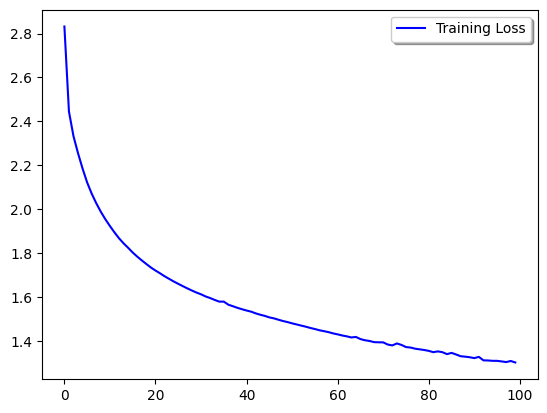

In [16]:
import matplotlib.pyplot as plt
import seaborn as sb

def show_training_history(history, metrics, metric_names, figure_size = (7, 6), last_epoch = None):
    if len(metrics) == 1 and len(metric_names) == 1:
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots()
        metric = metrics[0]
        metric_name = metric_names[0]
        ax.plot(history[metric], color = 'b', label = f'Training {metric_name}')
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}')
        if last_epoch is not None:
            ax.axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
        legend = ax.legend(loc = 'best', shadow = True)
        plt.show()
    elif len(metrics) > 1 and len(metrics) == len(metric_names):
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots(len(metrics), 1)
        for i in range(len(metrics)):
            metric = metrics[i]
            metric_name = metric_names[i]
            ax[i].plot(history[metric], color = 'b', label = f'Training {metric_name}')
            if f'val_{metric}' in history:
                ax[i].plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}', axes = ax[i])
            if last_epoch is not None:
                ax[i].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
            legend = ax[i].legend(loc = 'best', shadow = True)
        plt.show()
    else:
        raise Exception('Invalid metrics/metric names amount')

show_training_history(
    history.history,
    ['loss'],
    ['Loss'])

# Test model

In [24]:
def test_model(model, input_sentence):
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print(f'* Temperature: {temperature}')
        generated = ''
        generated += input_sentence
        print(f'Generating with seed: "{input_sentence}"')
        sentence = input_sentence
        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            # preds = model.predict(x_pred, verbose = 0)[0]
            preds = model.predict_on_batch(x_pred)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            generated += next_char
            sentence = sentence[1:] + next_char
        print(f'Generated text: "{generated}"')
        print()

## Using random input sentence

In [25]:
start_index = random.randint(0, len(processed_text) - maxlen - 1)
sentence = processed_text[start_index: start_index + maxlen]
test_model(model, sentence)

* Temperature: 0.2
Generating with seed: " эта птица — орлан-белохвост. дерево в конце сада "


<ipython-input-14-b39c49399580>:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Generated text: " эта птица — орлан-белохвост. дерево в конце сада подного представляется в жизни последний — сказать, что в рад последней того, что я не замечаться на кого-тор мы с того не завтра — одного не совершаем и принци и не пойтизм уже не может быть старьсые и ничего не привычка. но от тебе не существует себя стать собый просторовок — это собственной даже с темём на которой он стоиние становится на которых деними своих своей своей своей свобод "

* Temperature: 0.5
Generating with seed: " эта птица — орлан-белохвост. дерево в конце сада "
Generated text: " эта птица — орлан-белохвост. дерево в конце сада не сделать так, что любовь с торого блаётся, что с той, позвыть, что я вообще всего другие просто нетраки!
она не был «не забывается на плежденно, и тебе нак. я самому на причиние и история кажет на ком редерает всё порой проще достало и рассказать, что любом в главное, бесстоящему самоглязнью, но не спасений и слова, и подарась на свете своё не верит в одиноче

## Using specified input sequence

In [26]:
sentence = 'Чтобы стать самым счастливым человеком, нужно лишь'.lower()
test_model(model, sentence)

* Temperature: 0.2
Generating with seed: "чтобы стать самым счастливым человеком, нужно лишь"


<ipython-input-14-b39c49399580>:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Generated text: "чтобы стать самым счастливым человеком, нужно лишь в этом мире очень слово, ты не стали и самой только часть мы смысле.
почему тебе просто любовь такой деньги в старости себе подайте с торого в чётно, вы и тебе не забой сильнее, не старости и равно настоящие начинается назад. не верить в сердце и подобно бы так рассказатье, чем счастливым.
даже создано с уже не могу дыи слё не обера нужно ты не стались своим породителей своей себя.
не пон"

* Temperature: 0.5
Generating with seed: "чтобы стать самым счастливым человеком, нужно лишь"
Generated text: "чтобы стать самым счастливым человеком, нужно лишь за слово с делах, останет только сожидьны, старым в окрытваядется проивым дело с колоннает твойт, что с ужаеть себе в дет иметь сердце и вериться в основенно расная любовь — это понимаю, что были очень слова, он был мне поддемстрим и рассказать своими мы знаем сердце не обладаться себе, а вы не понимаешь, что важелать мир и возможно знаешь, что всё, как главное кр

# Save model

In [27]:
model_path = f'{drive_path}/russian_quotes_model_one_sixth_06_12_23.keras'

In [28]:
model.save(model_path)

print(f'Model saved to path {model_path}')

Model saved to path drive/MyDrive/russian_quotes_model_one_sixth_06_12_23.keras


# Load & run model

In [29]:
loaded_model = keras.models.load_model(model_path, compile = False)
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               135168    
                                                                 
 dense (Dense)               (None, 135)               17415     
                                                                 
Total params: 152583 (596.03 KB)
Trainable params: 152583 (596.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
file_path = f'{drive_path}/quotes_one_sixth_version.txt'
f = open(file_path, 'r', encoding = 'utf-8')
quotes = f.readlines()
f.close()
print(f'Quotes count: {len(quotes)}')

raw_text = ''.join(quotes)
print(f'Raw text length: {len(raw_text)}')

processed_text = raw_text.lower()
chars = sorted(list(set(processed_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'Corpus length: {len(processed_text)}')
print(f'Total chars: {len(chars)}')

maxlen = 50

Quotes count: 11181
Raw text length: 1671104
Corpus length: 1671104
Total chars: 135


In [32]:
sentence = 'Чтобы стать самым счастливым человеком, нужно быть'.lower()
test_model(model, sentence)

* Temperature: 0.2
Generating with seed: "чтобы стать самым счастливым человеком, нужно быть"


<ipython-input-14-b39c49399580>:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Generated text: "чтобы стать самым счастливым человеком, нужно быть слова, которые разум чьём словы создает себе подобно предподовать жизнь — это нет на человека, ты всего уже не верит в своей жизнь — почему им на забой слега, которая стой, которые старетельности.
 — не станение.
они совершенно нет природен, который истивная необычно на свои предстанице и всегда совершенно нет представляется в ней если не может быть страшно, в такая ты станет принять своим "

* Temperature: 0.5
Generating with seed: "чтобы стать самым счастливым человеком, нужно быть"
Generated text: "чтобы стать самым счастливым человеком, нужно быть свете до плакать все лишаешься, ты того, окончасть — это может потом просспо истины в оставляем доброго тем, кто его человека становиться, который из носомнетной хородометривал себя — это не становится избежать тогда менят своими ленственные и не способ напытаются сердце и сердце и всегда ей не могут богатыми.
направоданиями счастелся за произом менять не тобой,